# Load data

In [34]:
import pandas as pd
import numpy as np

In [53]:
df = pd.read_csv('clean_year_text_keywords.csv')
df.head()

,Id,year,text,keywords
0,24877594,2014.0,What we know and do not know about the cannab...,"['cannabinoid receptor 2', 'endocannabinoid', ..."
1,16889837,2006.0,Allosteric agonists of 7TM receptors: expandi...,NaN
2,31068464,2019.0,MRGPRX4 is a G protein-coupled receptor activ...,"['mrgprx4', 'bile acids', 'cholestasis', 'itch..."
3,30610192,2019.0,"Modulation of Gpr39, a G-protein coupled rece...",NaN
4,30289386,2018.0,Simulation of spontaneous G protein activatio...,"['g proteins', 'markov state models', 'alloste..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323870 entries, 0 to 323869
Data columns (total 4 columns):
Id          323870 non-null int64
year        323603 non-null float64
text        323870 non-null object
keywords    37845 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 9.9+ MB


# Build vocabulary

## normalize text

In [54]:
import spacy
import nltk
import re
import unicodedata

nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)

In [55]:
def lemmatize_text(text): # normalize word variant forms to the same word
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crashed yesterday , ours crash daily'

In [56]:
df.text = df.text.apply(lambda x: x.lower())

In [57]:
%%time
df.text = df.text.apply(lemmatize_text) # normalize word variants

CPU times: user 4h 10min 17s, sys: 13min 48s, total: 4h 24min 6s
Wall time: 5h 37min 31s


In [58]:
df.text = df.text.apply(lambda x: re.sub(r' +',' ',x)) # remove excessive space

In [59]:
def remove_puncta(text):
    pattern = r'[^a-z0-9\s\.]'
    text = re.sub(pattern, '', text)
    return text

In [60]:
df.text = df.text.apply(remove_puncta) # remove puncta

In [61]:
df.to_csv('norm_df.csv')

## Tokenize to sentence to create corpus

In [90]:
corpus = []
for i in range(df.text.shape[0]):
    corpus += df.text.iloc[i].strip().split('.')

In [91]:
with open('corpus.txt','w') as f:
    for i in range(len(corpus)):
        f.write(corpus[i])
        f.write('.')
        f.write('\n')

## Phrase modeling

In [3]:
from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import LineSentence
import itertools as it
import os

In [4]:
currentdir = os.getcwd()
def datadir(file):
    return currentdir+'/'+file
datadir('corpus.txt')

'/Users/shunling/Desktop/CapstoneProjects/NaturalLanguageProcessingGPCR/corpus.txt'

### from unigram to bigram

In [92]:
unigrams = LineSentence(datadir('corpus.txt'))
for s in it.islice(unigrams, 10,12):
    print(' '.join(s))
    print('')
for sentence in unigrams:
    print(sentence)
    break

allosteric agonist of 7tm receptor expand the pharmacological toolbox .

abstract approximately 1 of the genome of high organism encode seven transmembrane 7tm g protein couple receptor which control an extensive range of physiological process and represent drug target for nearly half of all drug that be prescribe currently .

['what', 'we', 'know', 'and', 'do', 'not', 'know', 'about', 'the', 'cannabinoid', 'receptor', '2', 'cb2', '.']


In [93]:
%%time
bigram_phrases = Phrases(unigrams) # train model
bigram_model = Phraser(bigram_phrases) # build model

CPU times: user 3min 40s, sys: 4.13 s, total: 3min 44s
Wall time: 3min 48s


In [94]:
for s in it.islice(unigrams, 10,12):
    print(' '.join(bigram_model[s]))
    print('')

allosteric agonist of 7tm receptor expand the pharmacological toolbox .

abstract approximately 1 of the genome of high organism encode seven_transmembrane 7tm g_protein couple receptor which control an extensive range of physiological_process and represent drug target for nearly_half of all drug that be prescribe currently .



In [98]:
%%time
with open('bigrams.txt','w') as f:
    for sent in unigrams:
        bigram_sent = ' '.join(bigram_model[sent]) # apply model
        f.write(bigram_sent)
        f.write('\n')

CPU times: user 3min 37s, sys: 1.71 s, total: 3min 39s
Wall time: 3min 40s


### from bigram to trigram

In [102]:
%%time
bigrams = LineSentence(datadir('bigrams.txt'))
trigram_phrases = Phrases(bigrams)
trigram_model = Phraser(trigram_phrases)
with open('trigrams.txt','w') as f:
    for sent in bigrams:
        tri_sent = ' '.join(trigram_model[sent])
        f.write(tri_sent)
        f.write('\n')

CPU times: user 7min 38s, sys: 4.04 s, total: 7min 42s
Wall time: 7min 46s


### from trigram to fourgram

In [106]:
%%time
trigrams = LineSentence(datadir('trigrams.txt'))
fourgram_phrases = Phrases(trigrams)
fourgram_model = Phraser(fourgram_phrases)
with open('fourgrams.txt','w') as f:
    for sent in trigrams:
        four_sent = ' '.join(fourgram_model[sent])
        f.write(four_sent)
        f.write('\n')

CPU times: user 8min 1s, sys: 4.67 s, total: 8min 5s
Wall time: 8min 10s


# Topic modeling with LDA with BOW

In [111]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import pickle 
warnings.simplefilter("ignore")

In [110]:
%%time
text = LineSentence(datadir('fourgrams.txt'))
dictionary = Dictionary(text)# bag of word, Id2word

CPU times: user 2min 36s, sys: 3.2 s, total: 2min 39s
Wall time: 2min 52s


In [113]:
dictionary.filter_extremes(no_above=0.4) 
dictionary.compactify()
dictionary.save(datadir('fourgram_dict_all.dict'))

In [114]:
def bow_generator(file):
    for text in LineSentence(file):
        yield dictionary.doc2bow(text)

In [117]:
MmCorpus.serialize(datadir('bow_corpus_all.mm'),bow_generator(datadir('fourgrams.txt')))

In [118]:
bow_corpus = MmCorpus(datadir('bow_corpus_all.mm')) # word count vectorizer

In [119]:
%%time
lda = LdaMulticore(bow_corpus,
                  num_topics = 50,
                  id2word = dictionary,
                  workers = 3)
lda.save(datadir('lda50'))

CPU times: user 29min 6s, sys: 13min 32s, total: 42min 39s
Wall time: 36min 34s


In [131]:
def explore_topic(topic_n, topn=25):
    print('{:30} {}'.format('term','frequency') + '\n')
    
    for term, frequency in lda.show_topic(topic_n, topn=25):
        print('{:30} {:.3f}'.format(term, round(frequency, 3)))

In [158]:
explore_topic(29)

term                           frequency

e.                             0.053
regulate                       0.050
mean                           0.041
neuronal                       0.040
cell                           0.040
endothelin                     0.038
ca2i                           0.037
growth                         0.037
cellular                       0.035
factor                         0.034
directly                       0.027
andor                          0.024
by                             0.024
angiotensin                    0.019
differentiation                0.016
generation                     0.016
26                             0.015
ca                             0.015
second_messenger               0.011
be                             0.010
function                       0.009
uterus                         0.009
fibroblast                     0.009
output                         0.009
that                           0.008


In [159]:
topics = {18:'neuroscience',19:'antidepressant',1:'beta receptor',7:'opioid',12:'pharmacology'}

In [160]:
%%time
lda = LdaMulticore(bow_corpus,
                  num_topics = 10,
                  id2word = dictionary,
                  workers = 3)
lda.save(datadir('lda10'))

CPU times: user 13min 47s, sys: 3min 10s, total: 16min 58s
Wall time: 17min 52s


In [173]:
explore_topic(9)

term                           frequency

0.                             0.082
1                              0.062
2                              0.050
3                              0.041
5                              0.037
4                              0.032
6                              0.020
nm                             0.020
day                            0.019
respectively                   0.016
7                              0.016
2.                             0.016
8                              0.014
for                            0.013
at                             0.012
p_0.                           0.010
be                             0.010
0                              0.010
01                             0.009
3.                             0.009
cell                           0.008
n                              0.008
10                             0.008
bmax                           0.007
microm                         0.007


## Neural Network Vectorization (Word2Vec)

In [2]:
import gensim
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import warnings 

warnings.filterwarnings(action = 'ignore') 

In [5]:
text = LineSentence(datadir('fourgrams.txt'))
for s in it.islice(text, 0,5):
    print(s[:-1])

['what', 'we', 'know', 'and', 'do_not', 'know_about', 'the', 'cannabinoid', 'receptor', '2', 'cb2']
['abstract', 'it', 'have', 'be', 'well_appreciate', 'that', 'the', 'endocannabinoid_system', 'can', 'regulate', 'immune_response', 'via', 'the', 'cannabinoid', 'receptor', '2', 'cb2', 'which', 'be', 'primarily', 'express', 'by', 'cell', 'of', 'the', 'hematopoietic', 'system']
['the', 'endocannabinoid_system', 'be', 'compose', 'of', 'receptor', 'ligand', 'and', 'enzyme', 'control', 'the', 'synthesis', 'and', 'degradation', 'of', 'endocannabinoid']
['along', 'with', 'endocannabinoid', 'both', 'plant_derive', 'and', 'synthetic_cannabinoid', 'have', 'be', 'show', 'to', 'bind', 'to', 'and', 'signal', 'through', 'cb2', 'via', 'g_protein', 'lead', 'to', 'both', 'inhibitory', 'and', 'stimulatory', 'signal', 'depend_on', 'the', 'biological_process']
['because', 'no', 'cannabinoid', 'ligand', 'have', 'be', 'identify', 'that', 'only', 'bind', 'to', 'cb2', 'the', 'generation', 'of', 'mouse_deficient

In [6]:
def sentenize(doc): #treat each abstract as sentence unit
    new_doc = []
    abstract = []
    for sent in doc:
        
        if sent != ['.']:
            if sent[0] == 'abstract':
                abstract += sent[1:-1]
            else:
                abstract += sent[:-1]
        else:
            new_doc.append(abstract)
            abstract = []

    return new_doc

In [7]:
%%time
abstracts = sentenize(text)

CPU times: user 23.3 s, sys: 5.03 s, total: 28.3 s
Wall time: 32.9 s


In [8]:
print(len(abstracts))
print(abstracts[0:1])

325620
[['what', 'we', 'know', 'and', 'do_not', 'know_about', 'the', 'cannabinoid', 'receptor', '2', 'cb2', 'it', 'have', 'be', 'well_appreciate', 'that', 'the', 'endocannabinoid_system', 'can', 'regulate', 'immune_response', 'via', 'the', 'cannabinoid', 'receptor', '2', 'cb2', 'which', 'be', 'primarily', 'express', 'by', 'cell', 'of', 'the', 'hematopoietic', 'system', 'the', 'endocannabinoid_system', 'be', 'compose', 'of', 'receptor', 'ligand', 'and', 'enzyme', 'control', 'the', 'synthesis', 'and', 'degradation', 'of', 'endocannabinoid', 'along', 'with', 'endocannabinoid', 'both', 'plant_derive', 'and', 'synthetic_cannabinoid', 'have', 'be', 'show', 'to', 'bind', 'to', 'and', 'signal', 'through', 'cb2', 'via', 'g_protein', 'lead', 'to', 'both', 'inhibitory', 'and', 'stimulatory', 'signal', 'depend_on', 'the', 'biological_process', 'because', 'no', 'cannabinoid', 'ligand', 'have', 'be', 'identify', 'that', 'only', 'bind', 'to', 'cb2', 'the', 'generation', 'of', 'mouse_deficient', 'in',

In [9]:
class callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.loss_s = 0
        
    def on_epoch_end(self,model):
            
        if self.epoch % 5 == 0:
            loss_e = int(model.get_latest_training_loss())
            loss = loss_e - self.loss_s
            self.loss_s = loss_e
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        self.epoch += 1     

In [10]:
%%time
feature_size = 300 # word vector dimensionality
window_context = 50 # context window size
min_word_count = 5 # minimum word count
sample = 1e-3 # Downsample setting for frequent words
model1 = Word2Vec(abstracts, #fourgrams abstract list tokenized in words
                 size = feature_size,
                 window = window_context,
                 min_count = min_word_count,
                 sample = sample,
                 sg=1,
                 compute_loss = True,
                 iter = 20,
                 workers = 3,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 130424536
Loss after epoch 5: 3793192
Loss after epoch 10: 0
Loss after epoch 15: 0
CPU times: user 1d 9h 53min 53s, sys: 9min 42s, total: 1d 10h 3min 35s
Wall time: 11h 51min 39s


In [15]:
model1.save('m300_50_5_3.model')

In [38]:
# view similar words based on gensim's model
def search_similar_words(search_terms,topn=10):
    similar_words = {search_term: [item[0] for item in model1.wv.most_similar([search_term], topn=topn)]
                  for search_term in search_terms}
    return similar_words
similar_words = search_similar_words(['dopamine','mu','a2a','gpr68','glp1'])
similar_words

{'dopamine': ['dopaminergic',
  'd2',
  'da',
  'd1',
  'apomorphine',
  'dopamine_da',
  'sulpiride',
  'd2_dopamine',
  'haloperidol',
  'dopamine_d2'],
 'mu': ['opioid',
  'delta',
  'kappa',
  'mu_opioid',
  'delta_opioid',
  'mu_delta',
  'kappa_opioid',
  'kappa_agonist',
  'dago',
  'morphine'],
 'a2a': ['adenosine_a2a',
  'a2a_adenosine',
  'a2b',
  'a1',
  'cgs_21680',
  'agonist_cgs21680',
  'a3',
  'cgs21680',
  'agonist_cgs_21680',
  'antagonist_zm241385'],
 'gpr68': ['proton_sense',
  'proton_sense_gpcr',
  'ogr1',
  'proton_sense_g_protein_couple',
  'acidic_microenvironment',
  'bex1',
  'isx',
  'ph_sense_g_protein_couple',
  'proton_sense_gpcrs',
  'tdag8'],
 'glp1': ['glucagon_like_peptide1_glp1',
  'glp1r',
  'glucagon_like_peptide_1',
  'glucagon_like_peptide1',
  'exendin4',
  'incretin',
  'native_glp1',
  'incretin_hormone',
  'glp1_analogue',
  'glp1_analog']}

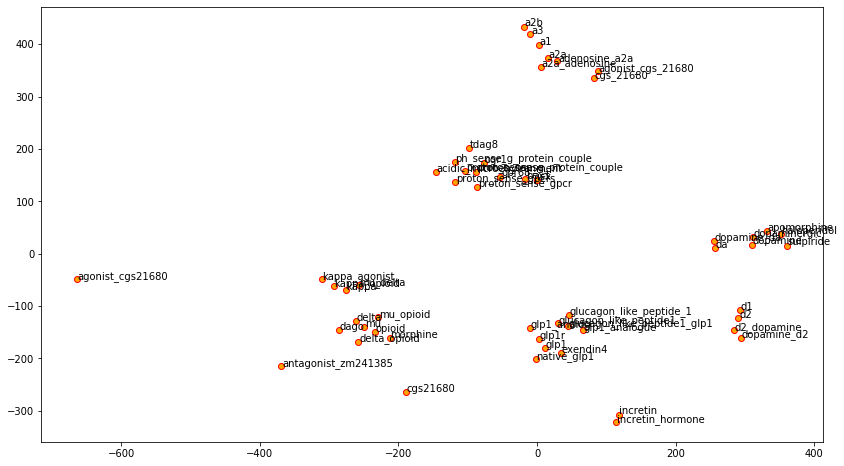

In [39]:
# visualizing similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = model1.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [50]:
def year_trends(interest,df):
    year = []
    for i in range(df.shape[0]):
        if interest in df.text.iloc[i]:
            year.append(df.year.iloc[i])
    return year

In [45]:
interest1 = search_similar_words(['functional_selectivity'],20)
interest1

{'functional_selectivity': ['biased_agonism',
  'biased_signal',
  'biased_signaling',
  'biased_ligand',
  'arrestin_recruitment',
  'biased_agonist',
  'intrinsic_efficacy',
  'g_protein_bias',
  'biased',
  'arrestin2_recruitment',
  'gpcr',
  'recruit_arrestin',
  'ligand_biased_signaling',
  'bret_biosensor',
  'partial_agonism',
  'relative_efficacy',
  'gpcrs',
  'arrestin_dependent',
  'over_arrestin2_recruitment',
  'active_conformation']}

In [80]:
from collections import Counter
import operator

In [71]:
def plot_year_trend(interest,df):
    years = year_trends(interest,df)
    c = Counter(years)
    sorted_c = sorted(c.items(), key=operator.itemgetter(0))
    x = [i[0] for i in sorted_c] # keyword list
    y = [i[1] for i in sorted_c] # keyword counts
    plt.plot(x,y)
    plt.xlim(min(x),2018)
    plt.show()

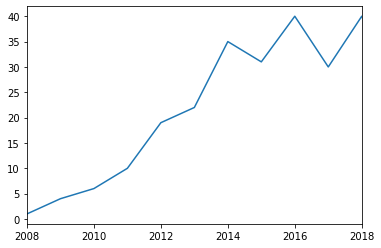

CPU times: user 6.56 s, sys: 135 ms, total: 6.7 s
Wall time: 7.01 s


In [72]:
%%time
plot_year_trend('biased signal',df)

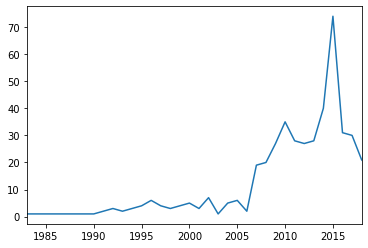

In [82]:
plot_year_trend('functional selectivity',df)

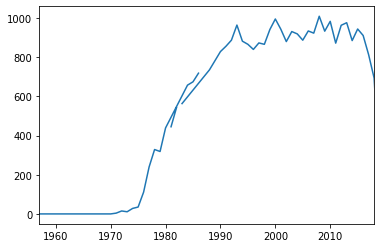

In [73]:
plot_year_trend('dopamine',df)

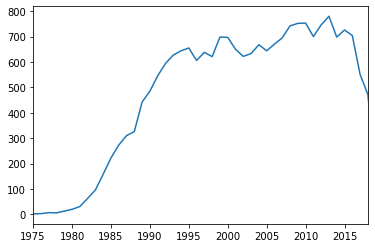

In [75]:
plot_year_trend('d2',df)

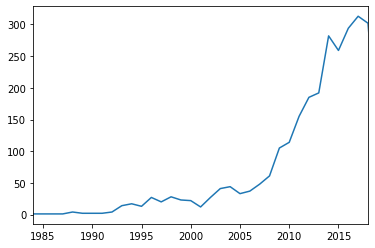

In [74]:
plot_year_trend('glp1',df)

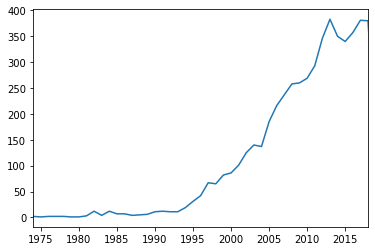

In [76]:
plot_year_trend('obesity',df)

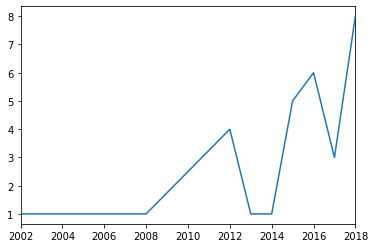

In [78]:
plot_year_trend('gpr68',df)

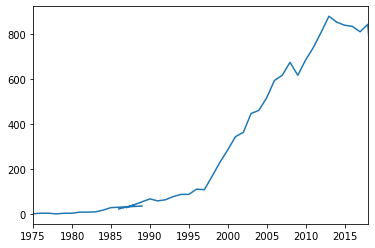

In [79]:
plot_year_trend('immune',df)

In [83]:
df.keywords.iloc[0]

"['cannabinoid receptor 2', 'endocannabinoid', 'immune regulatory', 'knockout', 'polymorphism']"

In [84]:
search_similar_words(['polymorphism'],20)

{'polymorphism': ['allele',
  'gene_polymorphism',
  'association_between',
  'genotype',
  'allele_frequency',
  'genetic_polymorphism',
  'genetic_variation',
  'genotype_frequency',
  'caucasian',
  'haplotype',
  'genetic_variant',
  'restriction_fragment_length_polymorphism',
  'single_nucleotide_polymorphism',
  'allelic_frequency',
  'genotyping',
  'linkage_disequilibrium',
  'genotype_distribution',
  'common_polymorphism',
  'candidate_gene',
  'single_nucleotide_polymorphism_snps']}